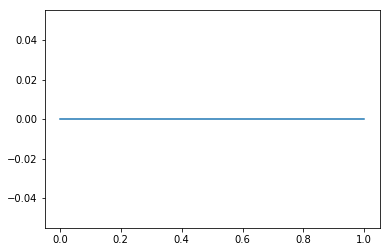

1 10 61
2 10 184
3 10 110


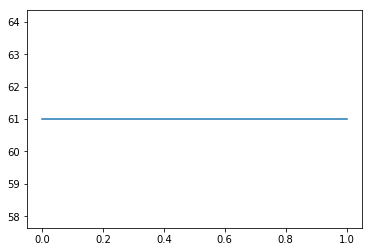

1 0 6
2 0 0
3 0 0


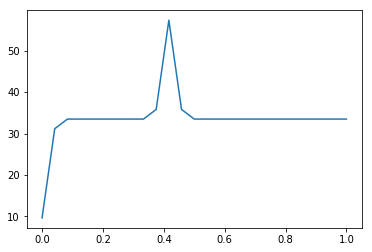

1 3 40
2 10 151
3 10 107


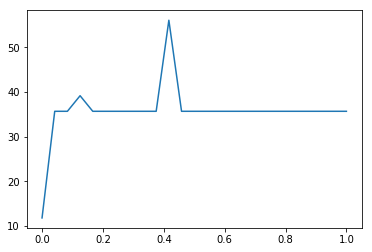

1 3 35
2 10 50
3 10 64


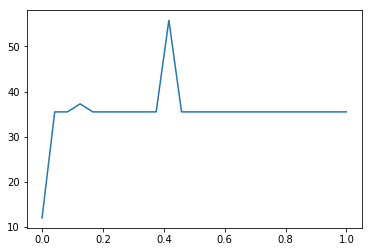

1 3 7
2 10 89
3 10 88


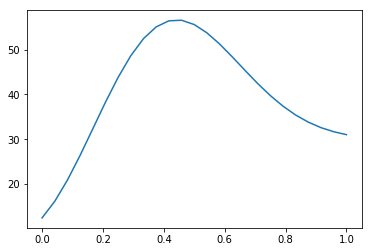

1 4 43
2 10 78
3 10 135


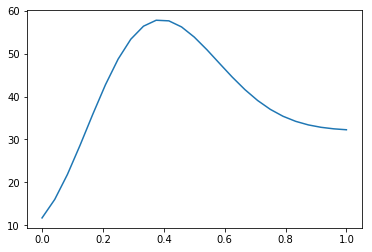

1 4 102
2 10 75
3 10 191


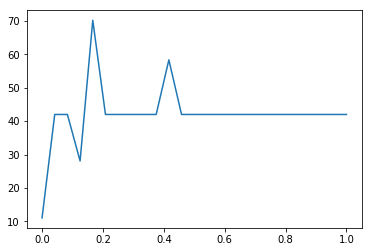

1 4 83
2 10 67
3 10 105


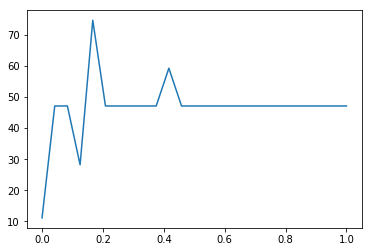

1 4 48
2 10 34
3 10 52


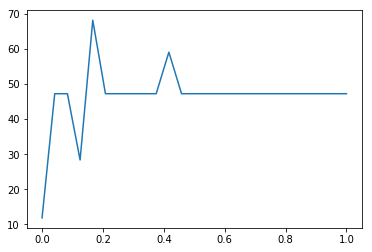

1 4 31
2 10 24
3 10 98


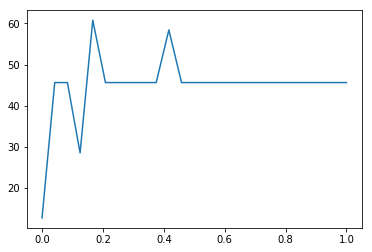

1 4 20
2 10 41
3 10 116


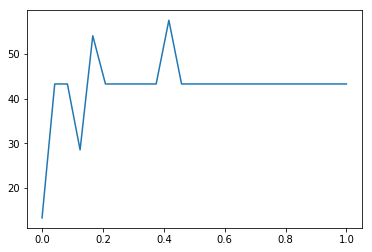

1 4 20
2 10 41
3 10 97


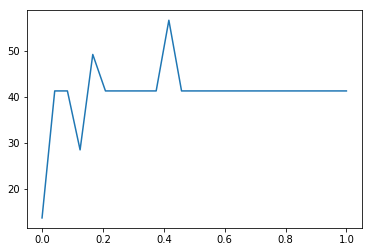

1 4 12
2 10 25
3 10 105


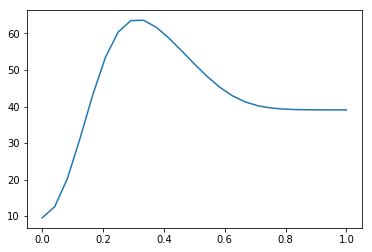

1 4 6
2 10 20
3 10 109


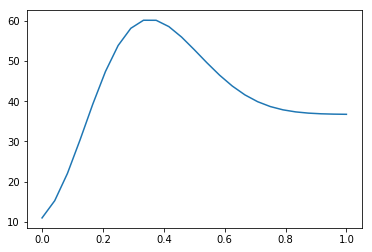

1 4 10
2 10 21
3 10 67


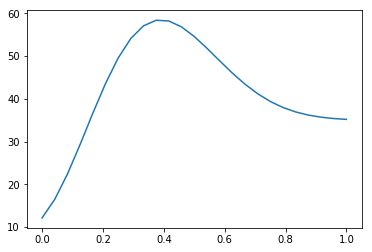

1 4 19
2 10 26
3 10 70


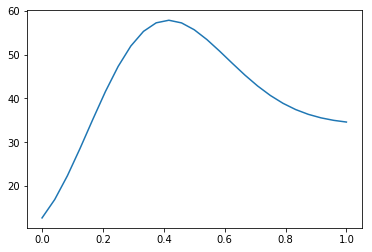

1 4 24
2 10 16
3 10 93


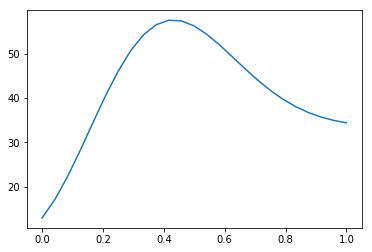

1 4 27
2 10 30
3 10 48


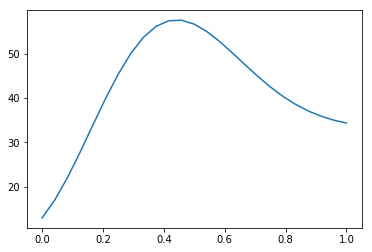

1 4 12
2 10 24
3 10 97


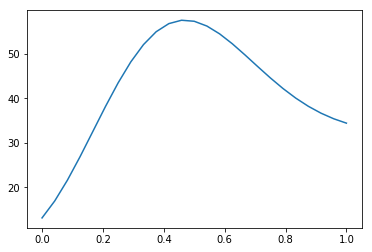

1 4 32
2 10 22
3 10 79
[{1: 10, 2: 10, 3: 10}, {1: 0, 2: 0, 3: 0}, {1: 3, 2: 10, 3: 10}, {1: 3, 2: 10, 3: 10}, {1: 3, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}, {1: 4, 2: 10, 3: 10}]


In [28]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/federico/Documents/GATTI/DIA_Project/Restart/')

import numpy as np
import matplotlib.pyplot as plt
from bidding_environment import *
from pricing_environment import *
from ts_learner import *
from gpts_learner import *
from data import p
from good_knapsack import *
import math
import pulp


# Sets initial data
n_arms_ads = 25 # number of arms for advertising
n_arms_pricing = 10 # number of arms for pricing

T = 20 # T for Times
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_arms_ads) # bids are a linspace
sigma = 10

# Presets regrets and rewards that are going to be computed
regrets_per_subcampaign = []
rewards_per_subcampaign = []

price_min = 50.0
price_max = 70.0
prices = np.linspace(price_min, price_max, n_arms_pricing)


ad_envs = [BiddingEnvironment(bids, sigma, subcampaign=subcampaign) for subcampaign in [1,2,3]]
meta_gpts_learners = [GPTS_Learner(n_arms=n_arms_ads, arms=bids) for subcampaign in [1,2,3]]
allocations = [
    {1: 10, 2:10, 3:10}
]

pricing_envs = [PricingEnvironment(n_arms=n_arms_pricing, prices=prices, p=p, subcampaign=subcampaign) for subcampaign in [1,2,3]]
ts_learners = [TS_Learner(n_arms=n_arms_pricing) for subcampaign in [1,2,3]]
for t in range(T):
    # 3 subcampaigns:
    rewards_per_subcampaign = []
    plt.plot(bids, meta_gpts_learners[0].means)
    plt.show()
    for subcampaign in [1, 2, 3]:
        ad_bid_to_try = allocations[-1][subcampaign] # pull the allocated arm
        n_clicks = ad_envs[subcampaign-1].round(ad_bid_to_try) # gets another random value from it
        rewards_from_ad = 0
        for t in range(int(n_clicks)):
            price_to_try = ts_learners[subcampaign-1].pull_arm()
            reward = pricing_envs[subcampaign-1].round(price_to_try)
            rewards_from_ad += reward*price_to_try
            ts_learners[subcampaign-1].update(price_to_try, reward, price_to_try)
        rewards_from_ad -= ad_bid_to_try
        print(subcampaign, ad_bid_to_try, rewards_from_ad)
        meta_gpts_learners[subcampaign-1].update(ad_bid_to_try, rewards_from_ad) # updates the learner
        # Appends to the rewards the values at lower CI
        rewards_per_subcampaign.append(meta_gpts_learners[subcampaign-1].means - meta_gpts_learners[subcampaign-1].sigmas)
    allocations.append(good_knapsack(bids, rewards_per_subcampaign, 1.0))

print(allocations)

In [2]:
import matplotlib.pyplot as plt

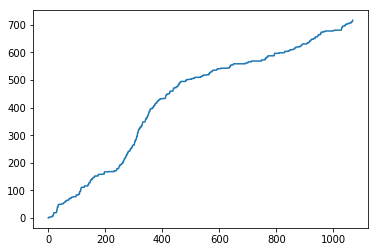

In [29]:
plt.plot(np.cumsum(ts_learners[0].collected_rewards))

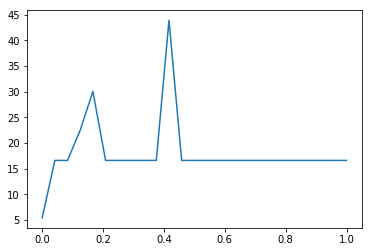

In [36]:
plt.plot(bids, meta_gpts_learners[0].means - meta_gpts_learners[0].sigmas)

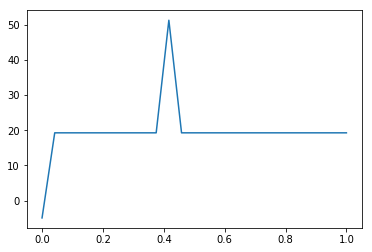

In [31]:
plt.plot(bids, meta_gpts_learners[1].means - meta_gpts_learners[1].sigmas)

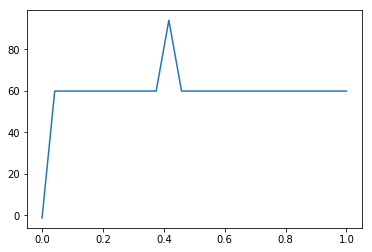

In [32]:
plt.plot(bids, meta_gpts_learners[2].means - meta_gpts_learners[2].sigmas)

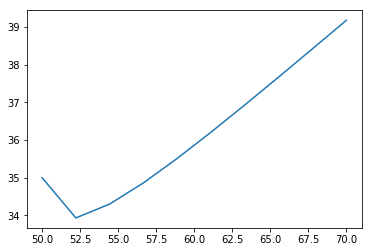

In [33]:
plt.plot(prices, prices*p[1](prices))